<a href="https://colab.research.google.com/github/tgloyn/DHDA_Michener/blob/main/Group_5_Predicting_Virtual_Care_Volumes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import tensorflow as tf
#!pip install pycaret
#import pycaret
#!pip install ydata-profiling
#from ydata_profiling import ProfileReport

## Data Import

In [2]:
from google.colab import files
uploaded = files.upload()


Saving CLEANED_VC_DATA_0.csv to CLEANED_VC_DATA_0.csv
Saving CLEANED_VC_DATA_1.csv to CLEANED_VC_DATA_1.csv
Saving CLEANED_VC_DATA_2.csv to CLEANED_VC_DATA_2.csv


In [3]:
data0 = pd.read_csv('CLEANED_VC_DATA_0.csv')
data1 = pd.read_csv('CLEANED_VC_DATA_1.csv')
data2 = pd.read_csv('CLEANED_VC_DATA_2.csv')

In [ ]:
print('shapes of initial dataframes: ',data0.shape, data1.shape, data2.shape, '\n# Rows of combined dataframe: ',(data0.shape[0] + data1.shape[0] + data2.shape[0]))

shapes of initial dataframes:  (734743, 9) (734743, 9) (734743, 9) 
# Rows of combined dataframe:  2204229


In [4]:
# Concatenating the three dataframes into one
df = pd.concat([data0, data1], ignore_index=True)
df = pd.concat([df, data2], ignore_index=True)

# Modifying column names for easier reference
df = df.rename(columns={'Cleaned_Visit_Number': 'Visit_number',
                                      'Cleaned_patient_id': 'patient_id',
                                      'Cleaned_provider_id': 'provider_id',
                                      'Cleaned_location_name': 'location_name'})

# Making column names all lowercase
df.columns = df.columns.str.lower()

# Converting appointment start time to datetime
df['appt_start_time'] = pd.to_datetime(df['appt_start_time'])

# Setting the dataframe index to be the Appointment start time column for easier time series analyses
df.set_index('appt_start_time', inplace=True)
df = df.sort_index()
df.shape

(2204229, 8)

In [ ]:
# Confirming no duplicated rows in the concatenated dataframe
df.duplicated().value_counts()

False    2204229
dtype: int64

In [ ]:
df.isna().sum()

appt_status                   0
appt_reschedule_time    1886366
appt_type                     0
care_modality                 0
visit_number                  0
patient_id                    0
provider_id               16077
location_name                 0
dtype: int64

# EDA

## General

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2204229 entries, 2022-08-01 04:30:00 to 2023-08-31 22:15:00
Data columns (total 8 columns):
 #   Column                Dtype  
---  ------                -----  
 0   appt_status           object 
 1   appt_reschedule_time  object 
 2   appt_type             object 
 3   care_modality         object 
 4   visit_number          int64  
 5   patient_id            int64  
 6   provider_id           float64
 7   location_name         object 
dtypes: float64(1), int64(2), object(5)
memory usage: 151.4+ MB


In [5]:
# Function to take df and apply time series specific columns
def set_columns(df):
  df = df.copy()
  df['appt_per_week'] = df.resample('W').size()
  df['appt_per_month'] = df.resample('M').size()
  df['appt_per_hour'] = df.resample('H').size()
  df['virtual_weekly'] = df[(df['care_modality'] == 'PHONE') | (df['care_modality'] == 'MS TEAMS') | (df['care_modality'] == 'TELEHEALTH')].resample('W').size()
  df['inperson_weekly'] = df[df['care_modality'] == 'FACE-TO-FACE'].resample('W').size()
  df['hour'] = df.index.hour
  df['month'] = df.index.month
  df['quarter'] = df.index.quarter
  df['day_of_week'] = df.index.dayofweek
  df['appt_per_day'] = df.resample('D').size()
  df['virtual_hourly'] = df[(df['care_modality'] == 'PHONE') | (df['care_modality'] == 'MS TEAMS') | (df['care_modality'] == 'TELEHEALTH')].resample('H').size()
  df['virtual_daily'] = df[(df['care_modality'] == 'PHONE') | (df['care_modality'] == 'MS TEAMS') | (df['care_modality'] == 'TELEHEALTH')].resample('D').size()
  df['inperson_daily'] = df[df['care_modality'] == 'FACE-TO-FACE'].resample('D').size()
  df['virtual_appt_ratio_hourly'] = df['virtual_hourly'] / df['appt_per_hour']
  df['virtual_appt_ratio_daily'] = df['virtual_daily'] / df['appt_per_day']
  df['virtual_appt_ratio_weekly'] = df['virtual_weekly'] / df['appt_per_week']
  return df

# Apply created function
df = set_columns(df)

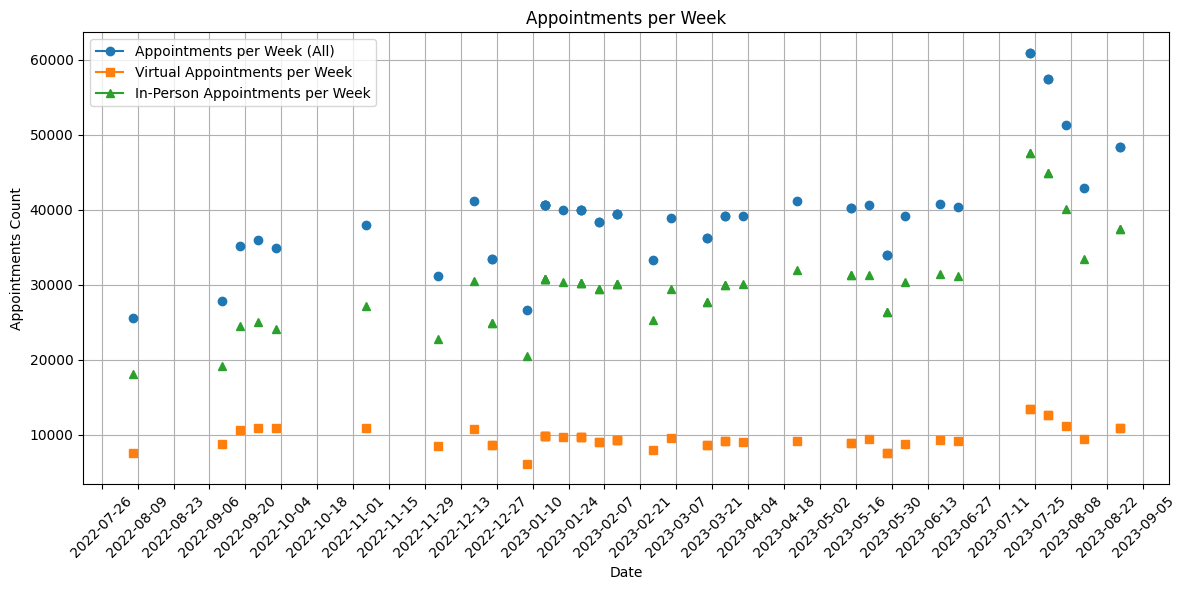

In [ ]:
# Plotting appointments per week total, comparing in-person and virtual modalities
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['appt_per_week'], marker='o', linestyle='-', label='Appointments per Week (All)')
plt.plot(df.index, df['virtual_weekly'], marker='s', linestyle='-', label='Virtual Appointments per Week')
plt.plot(df.index, df['inperson_weekly'], marker='^', linestyle='-', label='In-Person Appointments per Week')
plt.title('Appointments per Week')
plt.xlabel('Date')
plt.ylabel('Appointments Count')

# Customize x-axis date tick labels for more granularity (e.g., weekly)
date_format = mdates.DateFormatter('%Y-%m-%d')  # Change the format as needed
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))  # Adjust the interval as needed

plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

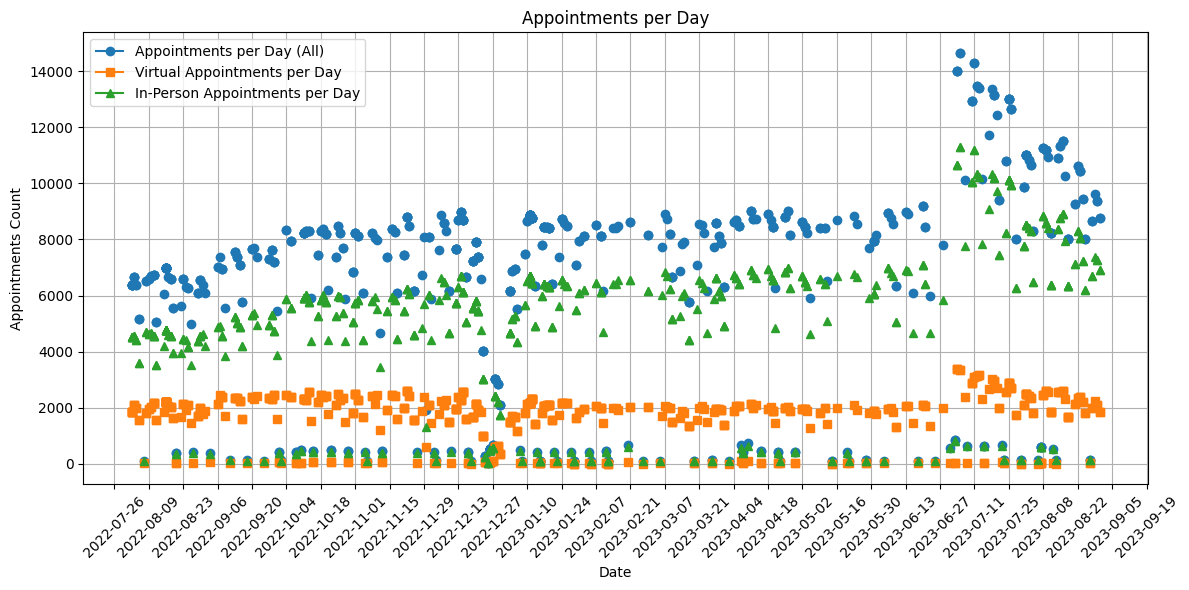

In [ ]:
# Plotting appointments per day total, comparing in-person and virtual modalities
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['appt_per_day'], marker='o', linestyle='-', label='Appointments per Day (All)')
plt.plot(df.index, df['virtual_daily'], marker='s', linestyle='-', label='Virtual Appointments per Day')
plt.plot(df.index, df['inperson_daily'], marker='^', linestyle='-', label='In-Person Appointments per Day')
plt.title('Appointments per Day')
plt.xlabel('Date')
plt.ylabel('Appointments Count')

# Customize x-axis date tick labels for more granularity (e.g., weekly)
date_format = mdates.DateFormatter('%Y-%m-%d')  # Change the format as needed
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))  # Adjust the interval as needed

plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

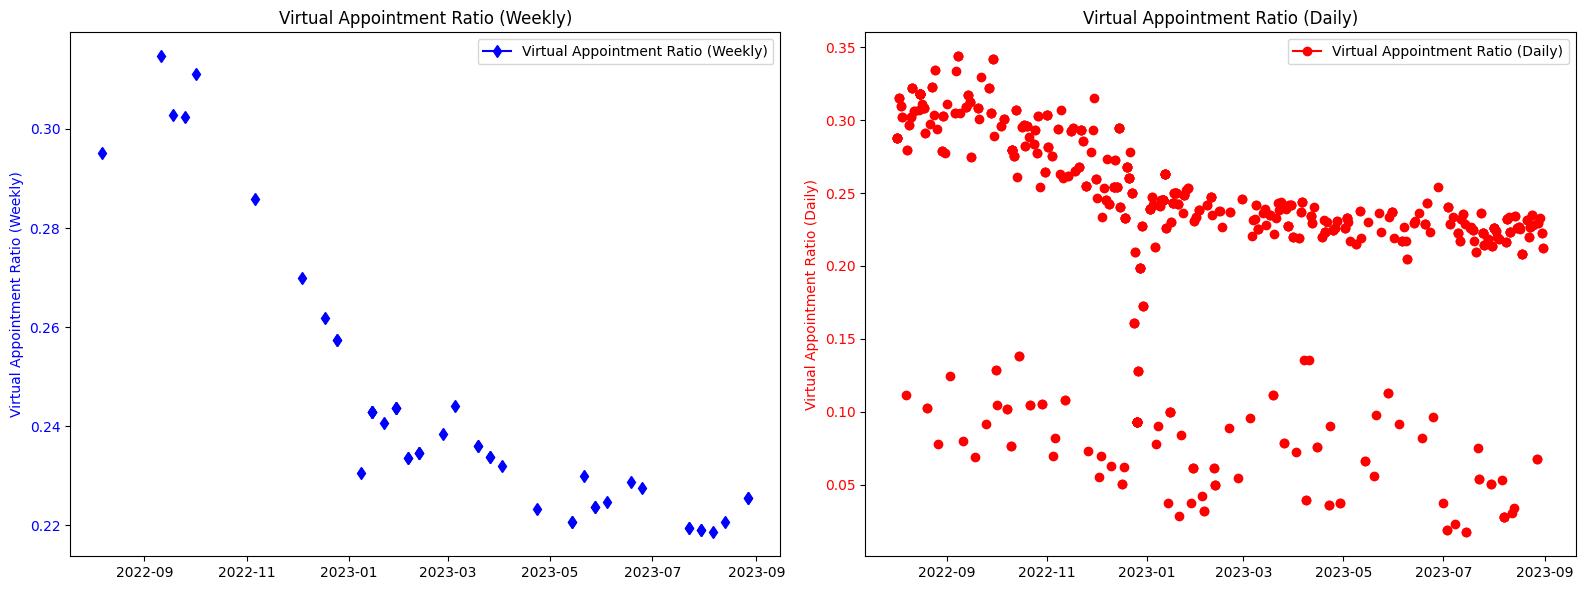

In [ ]:
# Create subplots with one row and two columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 'virtual_appt_ratio_weekly' on the first subplot
axes[0].plot(df.index, df['virtual_appt_ratio_weekly'], marker='d', linestyle='-', color='b', label='Virtual Appointment Ratio (Weekly)')
axes[0].set_ylabel('Virtual Appointment Ratio (Weekly)', color='b')
axes[0].tick_params(axis='y', labelcolor='b')
axes[0].set_title('Virtual Appointment Ratio (Weekly)')

# Plot 'virtual_appt_ratio_daily' on the second subplot
axes[1].plot(df.index, df['virtual_appt_ratio_daily'], marker='o', linestyle='-', color='r', label='Virtual Appointment Ratio (Daily)')
axes[1].set_ylabel('Virtual Appointment Ratio (Daily)', color='r')
axes[1].tick_params(axis='y', labelcolor='r')
axes[1].set_title('Virtual Appointment Ratio (Daily)')

# Customize x-axis date tick labels for more granularity (e.g., weekly)
#date_format = mdates.DateFormatter('%YYYY-%mm')  # Change the format as needed
#for ax in axes:
 #   ax.xaxis.set_major_formatter(date_format)
  #  ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))  # Adjust the interval as needed
   # ax.set_xticklabels(ax.get_xticks(), rotation=45)

# Add legends to each subplot
for ax in axes:
    ax.legend()

plt.tight_layout()
plt.show()

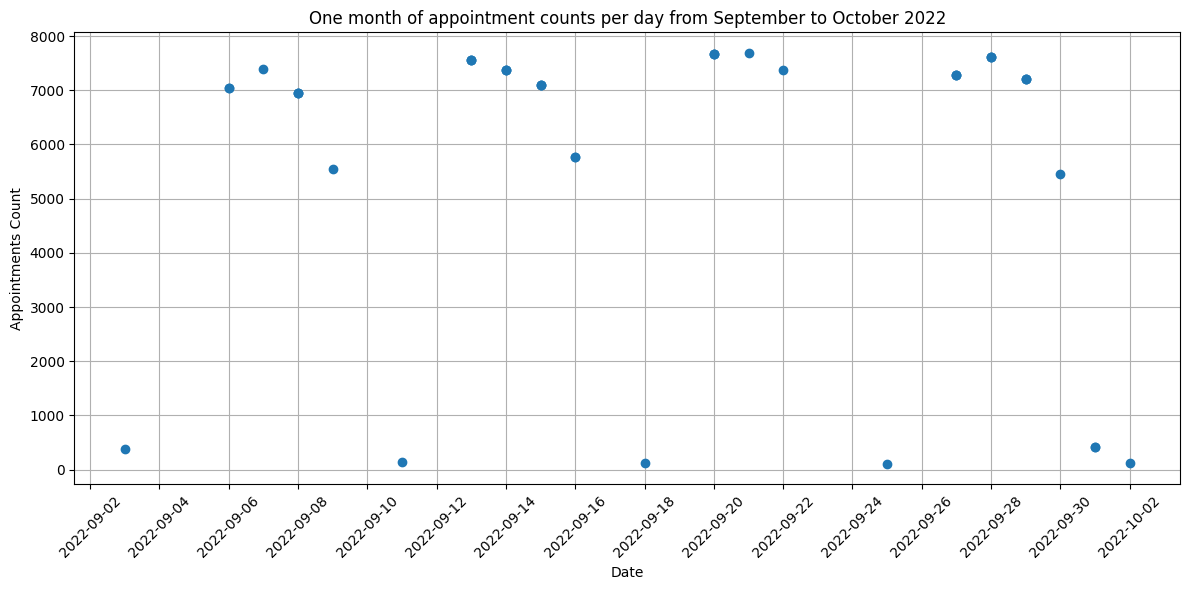

In [ ]:
# Filter the DataFrame for one month period (e.g., September 2023)
start_date = '2022-09-02'
end_date = '2022-10-02'
filtered_df = df[(df.index >= start_date) & (df.index <= end_date)]

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(filtered_df.index, filtered_df['appt_per_day'], marker='o', linestyle='-')
plt.title('One month of appointment counts per day from September to October 2022')
plt.xlabel('Date')
plt.ylabel('Appointments Count')

# Customize x-axis date tick labels for more granularity (e.g., daily)
date_format = mdates.DateFormatter('%Y-%m-%d')  # Change the format as needed
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))  # Adjust the interval as needed

plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(True)
plt.tight_layout()
plt.show()

## Appointment Date

In [ ]:
print('Earliest appointment date: ',df.index.min())
print('Latest appointment date: ', df.index.max())
print('Total number of days: ', df.index.max() - df.index.min())

Earliest appointment date:  2022-08-01 04:30:00
Latest appointment date:  2023-08-31 22:15:00
Total number of days:  395 days 17:45:00


In [ ]:
#Sub-setting dataframe into appointments made in 2022 versus 2023
df_2022 = df[df.index < '2023-01-01']
df_2023 = df[df.index > '2023-01-01']

## Location

In [ ]:
print(df['location_name'].value_counts().head(10))
print('\nNumber of unique Locations: ',df['location_name'].nunique())

Location_29    92254
Location_19    64106
Location_68    63459
Location_18    54025
Location_14    53418
Location_70    48440
Location_28    46737
Location_37    40160
Location_21    35485
Location_32    35336
Name: location_name, dtype: int64

Number of unique Locations:  387


In [ ]:
df[['location_name','appt_per_week']].sort_values(by='appt_per_week').head(10)

,location_name,appt_per_week
appt_start_time,,
2022-08-07,Location_208,25598.0
2023-01-08,Location_208,26592.0
2022-09-11,Location_208,27854.0
2022-12-04,Location_99,31205.0
2023-02-26,Location_99,33250.0
2022-12-25,Location_246,33461.0
2022-12-25,Location_152,33461.0
2023-05-28,Location_99,33907.0
2023-05-28,Location_99,33907.0


## Care Modality

In [ ]:
# Percent of each care modality across entire dataset
modal = pd.DataFrame(data = df['care_modality'].value_counts(normalize=True))
modal['2022'] = df_2022['care_modality'].value_counts(normalize=True)
modal['2023'] = df_2023['care_modality'].value_counts(normalize=True)
modal.columns = modal.columns=('ALL', '2022', '2023')
modal.loc['Virtual Care Total'] = [modal.iloc[1:4,0].sum(), modal.iloc[1:4,1].sum(), modal.iloc[1:4,2].sum()]
round(modal,2)

,ALL,2022,2023
FACE-TO-FACE,0.75,0.72,0.77
PHONE,0.13,0.19,0.10
MS TEAMS,0.11,0.08,0.12
TELEHEALTH,0.01,0.01,0.01
Virtual Care Total,0.25,0.28,0.23


In [ ]:
# Appointment type percentages for in-peron only
df[df['care_modality'] == 'FACE-TO-FACE']['appt_type'].value_counts(normalize=True)

OTHER        0.497849
FOLLOW UP    0.409061
NEW          0.093090
Name: appt_type, dtype: float64

In [ ]:
# Appointment type percentages for virtual only
df[(df['care_modality'] == 'MS TEAMS') | (df['care_modality'] == 'PHONE') | (df['care_modality'] == 'TELEHEALTH')]['appt_type'].value_counts(normalize=True)

FOLLOW UP    0.734213
NEW          0.163222
OTHER        0.102566
Name: appt_type, dtype: float64

There appears to be a greater proportion of appointments being a follow-up when the modality is virtual (73%) versus face-to-face (41%)

In [ ]:
# Appointment type percentages in 2022 for in-person only
df_2022[df_2022['care_modality'] == 'FACE-TO-FACE']['appt_type'].value_counts(normalize=True)

OTHER        0.531820
FOLLOW UP    0.383104
NEW          0.085076
Name: appt_type, dtype: float64

In [ ]:
# Appointment type percentages in 2023 for in-person only
df_2023[df_2023['care_modality'] == 'FACE-TO-FACE']['appt_type'].value_counts(normalize=True)

OTHER        0.481925
FOLLOW UP    0.421229
NEW          0.096847
Name: appt_type, dtype: float64

In [ ]:
# Appointment type percentages in 2022 for virtual only
df_2022[(df_2022['care_modality'] == 'MS TEAMS') | (df_2022['care_modality'] == 'PHONE') | (df_2022['care_modality'] == 'TELEHEALTH')]['appt_type'].value_counts(normalize=True)

FOLLOW UP    0.737577
NEW          0.179278
OTHER        0.083145
Name: appt_type, dtype: float64

In [ ]:
# Appointment type percentages in 2023 for virtual only
df_2023[(df_2023['care_modality'] == 'MS TEAMS') | (df_2023['care_modality'] == 'PHONE') | (df_2023['care_modality'] == 'TELEHEALTH')]['appt_type'].value_counts(normalize=True)

FOLLOW UP    0.732094
NEW          0.153112
OTHER        0.114794
Name: appt_type, dtype: float64

##Patient & Physician

In [ ]:
print('Number of unique physician IDs: ', df['provider_id'].nunique())
print('Number of unique patient IDs: ',df['patient_id'].nunique())

print('\nNumber of patients per physician: ', round(df['patient_id'].nunique() / df['provider_id'].nunique()))

Number of unique physician IDs:  2970
Number of unique patient IDs:  308301

Number of patients per physician:  104


# Train/Test Split

In [25]:
df['virtual_appt_ratio_hourly'].dropna().shape[0] - 931842*0.2

745473.6

In [26]:
train = df['virtual_appt_ratio_hourly'].dropna().iloc[:745473]
test = df['virtual_appt_ratio_hourly'].dropna().iloc[745473:]

train.shape, test.shape

((745473,), (186369,))

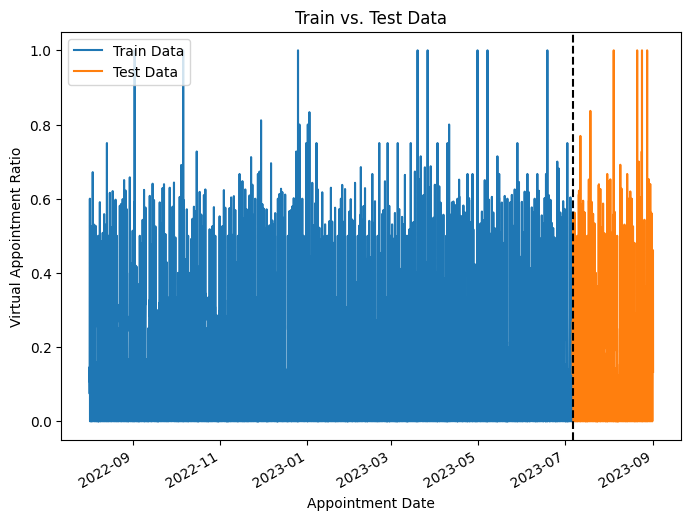

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the 'train' data on the same axis
train.plot(label='Train Data', ax=ax)

# Plot the 'test' data on the same axis
test.plot(label='Test Data', ax=ax)

# Add labels, titles
plt.xlabel('Appointment Date')
plt.ylabel('Virtual Appointment Ratio')
plt.title('Train vs. Test Data')

ax.axvline('2023-07-06 08:00:00', color='black', ls='--')
ax.legend()
plt.show()

In [31]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [28]:
train = pd.DataFrame(train)
test = pd.DataFrame(test)

In [32]:
X_train, y_train = create_features(train, label='virtual_appt_ratio_hourly')
X_test, y_test = create_features(test, label='virtual_appt_ratio_hourly')

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((745473, 8), (745473,), (186369, 8), (186369,))

#Modeling

## XGBoost

In [38]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# Instantiating model parameters
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=10) # Change verbose to True if you want to see it train

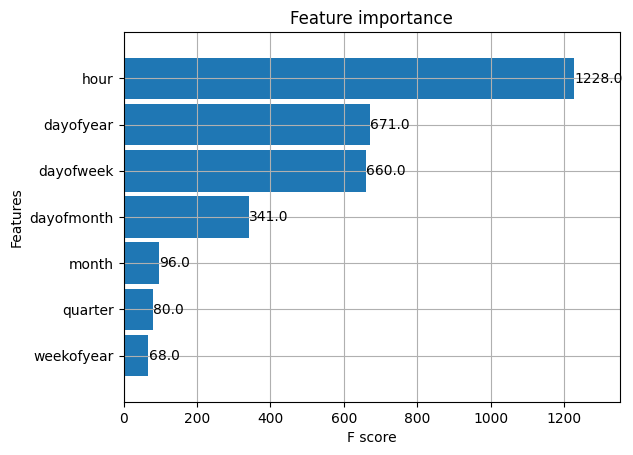

In [ ]:
# Importance of features
_ = plot_importance(reg, height=0.9)

In [ ]:
# Using the model to predict on the test set
test['prediction'] = reg.predict(X_test)

In [ ]:
# Concatenating train and test set dataframes
all = pd.concat([train, test], sort=False)

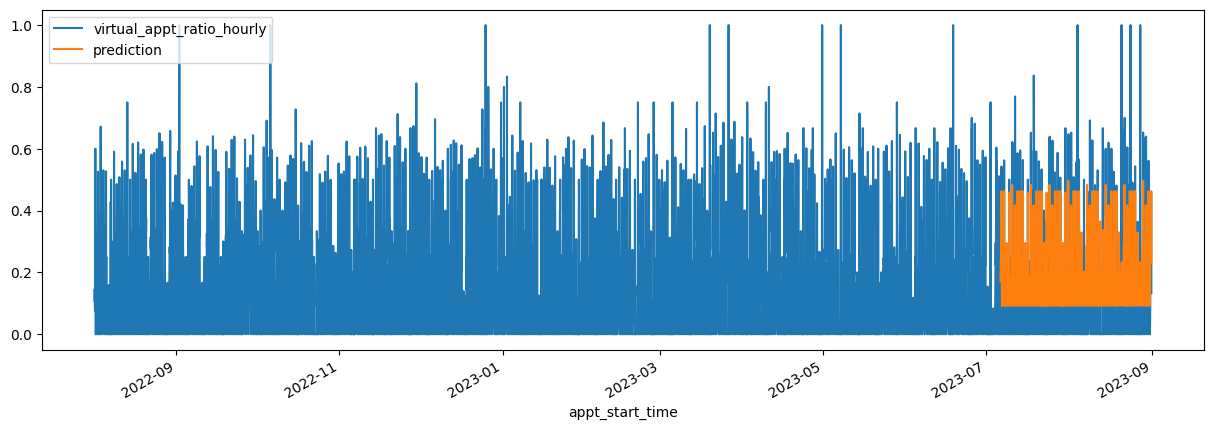

In [ ]:
# Plot comparing the actual versus predicted values
_ = all[['virtual_appt_ratio_hourly','prediction']].plot(figsize=(15, 5))

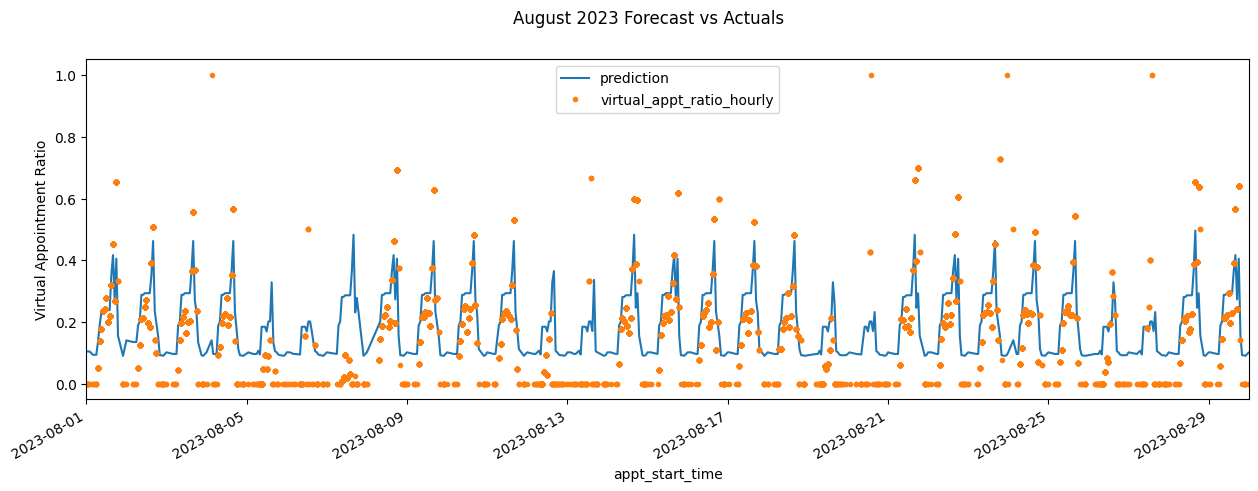

In [ ]:
# Plot the forecast with the actuals for August 2023
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = all[['prediction', 'virtual_appt_ratio_hourly']].plot(ax=ax,
                                              style=['-','.'])
plt.ylabel('Virtual Appointment Ratio')
ax.set_xbound(lower='2023-08-01', upper='2023-08-30')
plot = plt.suptitle('August 2023 Forecast vs Actuals')

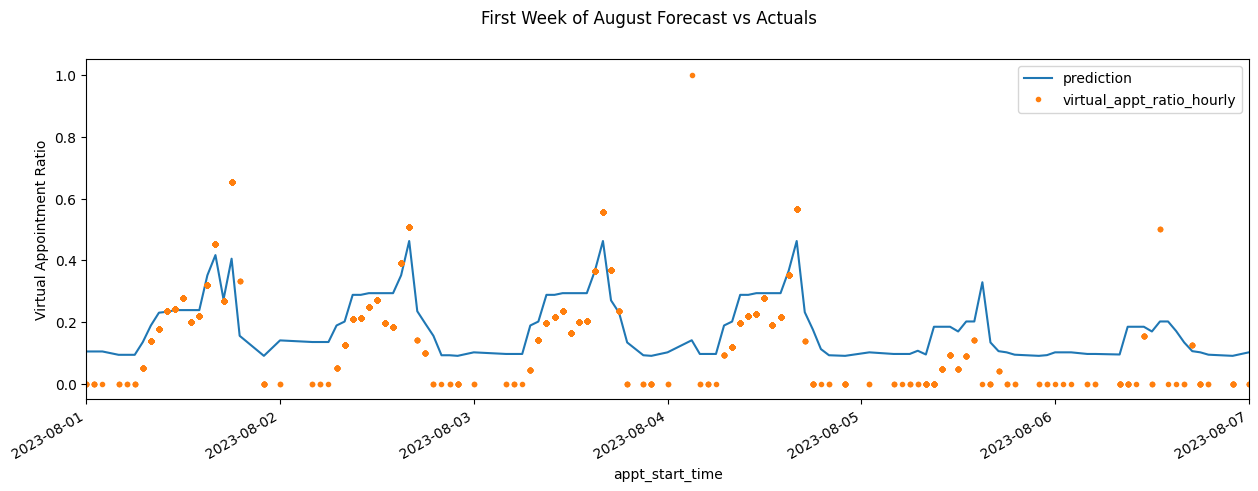

In [ ]:
# Plot the forecast with the actuals for first week in August 2023
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = all[['prediction', 'virtual_appt_ratio_hourly']].plot(ax=ax,
                                              style=['-','.'])
plt.ylabel('Virtual Appointment Ratio')
ax.set_xbound(lower='2023-08-01', upper='2023-08-07')
plot = plt.suptitle('First Week of August Forecast vs Actuals')

Error Metrics

In [ ]:
print('Mean Squared Error: ', mean_squared_error(y_true=test['virtual_appt_ratio_hourly'],
                   y_pred=test['prediction']))
print('Mean Absolute Error: ', mean_absolute_error(y_true=test['virtual_appt_ratio_hourly'],
                   y_pred=test['prediction']))

Mean Squared Error:  0.004215721895336573
Mean Absolute Error:  0.0514736075061407


In [ ]:
# Creating table to identify top 10 worst predictions made on the test set
test['error'] = test['virtual_appt_ratio_hourly'] - test['prediction']
test['abs_error'] = test['error'].apply(np.abs)
error_by_day = test.groupby(['year','month','dayofmonth']) \
    .mean()[['virtual_appt_ratio_hourly','prediction','error','abs_error']]

In [ ]:
error_by_day.sort_values('error', ascending=True).head(10)

virtual_appt_ratio_hourly  prediction     error  \
year month dayofmonth                                                    
2023 8     7                            0.025620    0.272791 -0.247171   
           12                           0.042490    0.172543 -0.130053   
           19                           0.050459    0.177210 -0.126752   
           5                            0.039696    0.157105 -0.117409   
     7     29                           0.018099    0.129572 -0.111473   
           15                           0.021513    0.129607 -0.108094   
           23                           0.038351    0.143373 -0.105021   
           8                            0.031281    0.133445 -0.102164   
     8     13                           0.041096    0.140164 -0.099068   
     7     16                           0.041429    0.135795 -0.094366   

                       abs_error  
year month dayofmonth             
2023 8     7            0.247171  
           12           0.132573  
           19           0.127839  
           5            0.117409  
     7     29           0.111473  
           15           0.108094  
           23           0.113367  
           8            0.105587  
     8     13           0.142457  
     7     16           0.105526

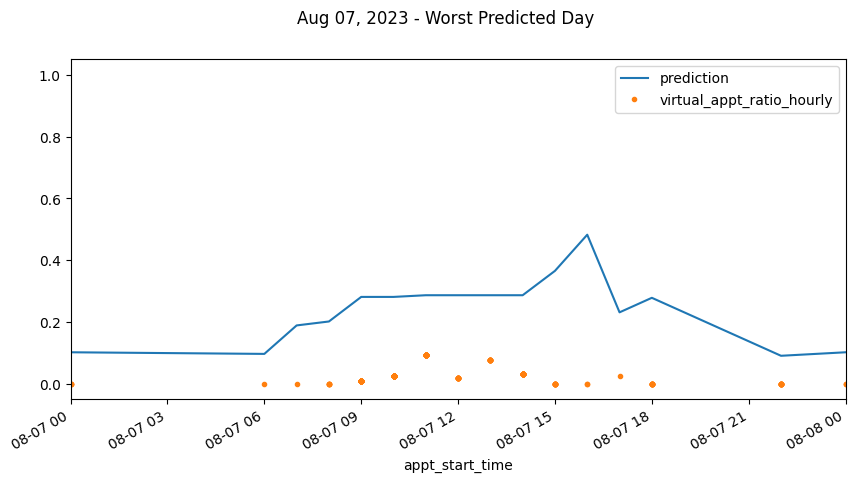

In [ ]:
# Plotting the worst predicted day from the test set
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = all[['prediction','virtual_appt_ratio_hourly']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='2023-08-07', upper='2023-08-08')
plot = plt.suptitle('Aug 07, 2023 - Worst Predicted Day')

## XGBoost with Cross-Validation and Lag features

In [6]:
from sklearn.model_selection import TimeSeriesSplit
# test size is 20% of the df divided by 5
tss = TimeSeriesSplit(n_splits=5, test_size=149094, gap=24)

In [ ]:
fig, axs = plt.subplots(5,1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
  train = df.iloc[train_idx]
  test = df.iloc[val_idx]
  train['virtual_appt_ratio_hourly'].plot(ax=axs[fold], label='Training Set', title=f'Data Train/Test Split Fold {fold}')
  test['virtual_appt_ratio_hourly'].plot(ax=axs[fold], label='Test Set')
  axs[fold].axvline(test.index.min(), color='black', ls='--')
  fold += 1
plt.show()

In [33]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    return df

In [8]:
def add_lags(df):
  target_map = df['virtual_appt_ratio_hourly'].to_dict()
  df['lag1'] = (df.index - pd.Timedelta('30 days')).map(target_map)
  df['lag2'] = (df.index - pd.Timedelta('180 days')).map(target_map)
  df['lag3'] = (df.index - pd.Timedelta('364 days')).map(target_map)
  return df

In [9]:
lag_df = add_lags(df)

In [63]:
subset_lag_df = lag_df[['virtual_appt_ratio_hourly','lag1', 'lag2', 'lag3']].dropna()
subset_lag_df.shape

(96215, 4)

In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=3848, gap=24)


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(subset_lag_df):
    train = subset_lag_df.iloc[train_idx]
    test = subset_lag_df.iloc[val_idx]

    train = create_features(train, label='virtual_appt_ratio_hourly')
    test = create_features(test, label='virtual_appt_ratio_hourly')

    FEATURES = ['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear', 'lag1', 'lag2', 'lag3']
    TARGET = 'virtual_appt_ratio_hourly'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

In [65]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 0.0331
Fold scores:[0.023525036937141083, 0.041682738330421285, 0.03327858926203305, 0.04164710299441611, 0.02512577987523154]


## Predicting the future

In [66]:
# Retrain on all data
df_train = create_features(subset_lag_df)

FEATURES = ['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear', 'lag1', 'lag2', 'lag3']
TARGET = 'virtual_appt_ratio_hourly'

X_all = df_train[FEATURES]
y_all = df_train[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:0.27765


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:44:55] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:0.10775
[200]	validation_0-rmse:0.04981
[300]	validation_0-rmse:0.03315
[400]	validation_0-rmse:0.02836
[499]	validation_0-rmse:0.02624


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [67]:
df_train.index.max()

Timestamp('2023-08-31 18:00:00')

In [68]:
# Create future dataframe
future = pd.date_range('2023-08-31 18:00:00','2024-08-31 18:00:00', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df_train['isFuture'] = False
df_and_future = pd.concat([df_train, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [70]:
future_w_features = df_and_future.query('isFuture').copy()

In [71]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

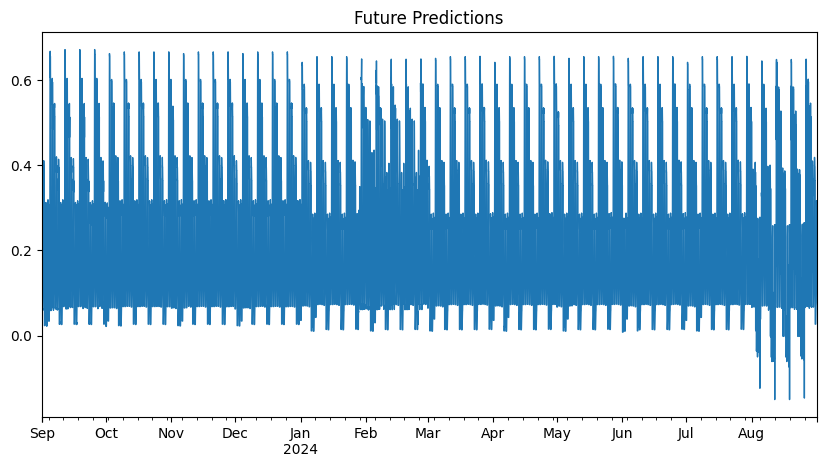

In [73]:
future_w_features['pred'].plot(figsize=(10, 5),
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

Text(0, 0.5, 'Virtual Appointment Ratio Hourly')

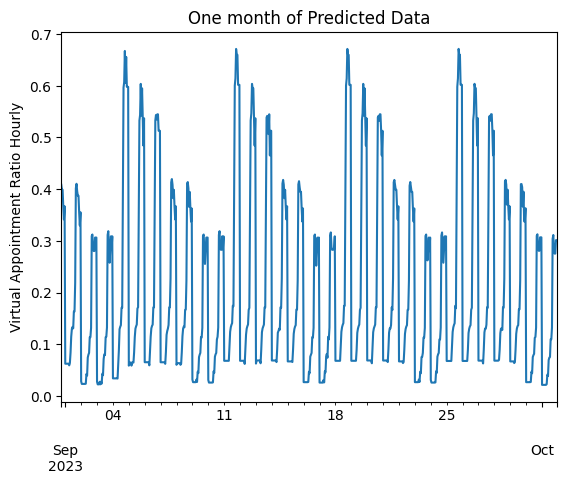

In [86]:
future_w_features['pred'].iloc[:750].plot()
plt.title('One month of Predicted Data')
plt.ylabel('Virtual Appointment Ratio Hourly')